In [1]:
# Common loss class
class Loss:
    # Calculates the data and regularization losses
    def regularization_loss(self):
        # 0 by default
        regularization_loss = 0

        # Calculate regularization loss
        # itrate all trainable layers
        for layer in self.trainable_layers:
        
            # L1 regularization - weights
            # calculate only when factor greater than 0
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
    
            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
    
            # L1 regularization - biases
            # calculate only when factor greater than 0
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(np.abs(layer.biases * layer.biases))
    
        return regularization_loss

    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
    
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Add accumulated sum of losses and sample count
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return loss and regularization loss
        return data_loss, self.regularization_loss()

    # Calculates accumulated loss
    def calculate_accumulated(self, *, include_regularization=False):
        # Calculate mean loss
        data_loss = self.accumulated_sum / self.accumulated_count
        # If just data loss - return it
        if not include_regularization:
            return data_loss
        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    # Reset variables for accumulated loss
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

In [2]:
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7) 
        # Ensure any of the probabilities is neither 0 or 1

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis =1
            )

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We will use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

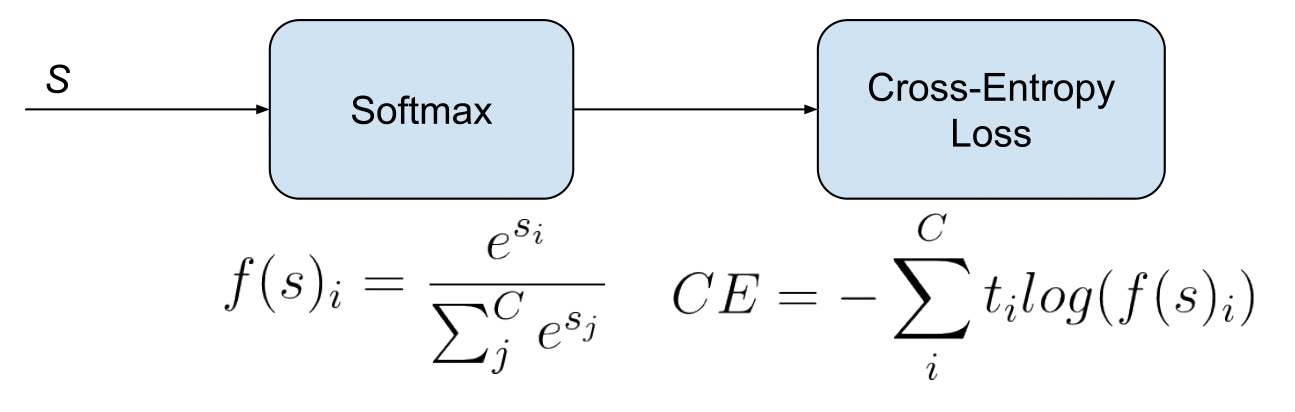

In [ ]:
å